# Stamp 03: Sanity Checks

**Question:** Does Goldilocks behave the way theory predicts?

Before we can use Goldilocks to test hypotheses about token dynamics, we need to verify the basics:

1. **Does h_mean converge?** — Track mean hidden state, check for stabilization
2. **Do dead tokens move?** — Gradient magnitude at each step (the Stamp mystery)
3. **Do dead tokens move together?** — Cosine similarity between dead token movements
4. **Is movement related to h_mean?** — Correlation between drift direction and h_mean
5. **Do centroids separate?** — Angular separation between dead and live token clouds

If these check out, Goldilocks is a valid model organism. If not, we need to understand why.

---

*Jeffery Harrell & Alpha, December 1, 2025*

## Goldilocks Foundation

Standard setup from the reference template.

In [1]:
# === GOLDILOCKS REFERENCE PARAMETERS ===
import torch

GOLDILOCKS_DATA = "../Goldilocks/data"
TOKENIZER_PATH = f"{GOLDILOCKS_DATA}/tokenizer.json"
TOKENS_PATH = f"{GOLDILOCKS_DATA}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{GOLDILOCKS_DATA}/token_census.json"

N_LAYERS = 4
D_MODEL = 128
N_HEADS = 2
D_FF = 256
SEQ_LEN = 128
DROPOUT = 0.0

BATCH_SIZE = 8
LEARNING_RATE = 1e-3
MODEL_DTYPE = torch.bfloat16

RANDOM_SEED = 42

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
from tokenizers import Tokenizer
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")

Device: mps


In [3]:
# Load tokenizer and data
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()

tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)

with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)
dead_token_ids = set(census['dead_token_ids'])

# Create masks
dead_mask = torch.zeros(vocab_size, dtype=torch.bool)
for tid in dead_token_ids:
    dead_mask[tid] = True
live_mask = ~dead_mask

print(f"Vocab: {vocab_size:,} | Dead: {dead_mask.sum().item():,} | Live: {live_mask.sum().item():,}")

Vocab: 3,988 | Dead: 1,914 | Live: 2,074


In [4]:
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]

dataset = TokenDataset(all_tokens, SEQ_LEN)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight  # Weight tying
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
        self._last_h = None  # Store last hidden state for inspection
        
        # Explicit initialization
        self._init_weights()
    
    def _init_weights(self):
        """Initialize token embeddings explicitly. No magic."""
        # Token embeddings (W): N(0, 0.02) via torch.randn * 0.02
        # This matches Qwen's initializer_range and GPT-2 convention.
        with torch.no_grad():
            self.tok_emb.weight.copy_(torch.randn(self.tok_emb.weight.shape) * 0.02)
        # pos_emb: leave as PyTorch default (not part of our investigation)
    
    def forward(self, x):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1
            )
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        h = self.ln_f(h)
        self._last_h = h.detach()  # Store for inspection
        return self.head(h)

model = GPT(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    d_ff=D_FF,
    seq_len=SEQ_LEN,
    dropout=DROPOUT
).to(device).to(MODEL_DTYPE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

print(f"Model: {sum(p.numel() for p in model.parameters()):,} params (tok_emb explicit: torch.randn * 0.02)")

Model: 1,057,024 params (tok_emb explicit: torch.randn * 0.02)


## Capture Initial State

In [6]:
# Record initial W
W_init = model.tok_emb.weight.detach().cpu().float().clone()

# Initial centroids
centroid_dead_init = W_init[dead_mask].mean(dim=0)
centroid_live_init = W_init[live_mask].mean(dim=0)

print(f"Initial dead centroid norm: {centroid_dead_init.norm():.6f}")
print(f"Initial live centroid norm: {centroid_live_init.norm():.6f}")

# Initial angle between centroids
cos_init = F.cosine_similarity(centroid_dead_init.unsqueeze(0), centroid_live_init.unsqueeze(0)).item()
angle_init = np.degrees(np.arccos(np.clip(cos_init, -1, 1)))
print(f"Initial angle between centroids: {angle_init:.1f}°")

Initial dead centroid norm: 0.005896
Initial live centroid norm: 0.004750
Initial angle between centroids: 86.7°


## The Experiment

Train for 100 steps, recording at each step:
- h_mean (mean hidden state across batch)
- Dead token gradient magnitude
- Dead token movement direction (cosine similarity between movements)
- Centroid positions

In [7]:
NUM_STEPS = 100

# Storage
h_means = []              # Mean hidden state at each step
h_mean_norms = []         # Norm of h_mean
h_mean_stability = []     # Cosine sim between consecutive h_means

dead_grad_norms = []      # Mean gradient norm for dead tokens
live_grad_norms = []      # Mean gradient norm for live tokens

dead_move_coherence = []  # How coherently dead tokens move together
dead_move_vs_h = []       # Correlation between dead movement and h_mean

centroid_angles = []      # Angle between dead and live centroids
centroid_dead_norms = []  # Norm of dead centroid
centroid_live_norms = []  # Norm of live centroid

In [8]:
model.train()
loader_iter = iter(loader)

W_prev = model.tok_emb.weight.detach().cpu().float().clone()
h_mean_prev = None

for step in tqdm(range(NUM_STEPS)):
    # Get batch
    try:
        x, y = next(loader_iter)
    except StopIteration:
        loader_iter = iter(loader)
        x, y = next(loader_iter)
    x, y = x.to(device), y.to(device)
    
    # Forward pass
    optimizer.zero_grad()
    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
    
    # Capture h_mean BEFORE backward (from stored _last_h)
    h = model._last_h  # [B, T, D]
    h_mean = h.mean(dim=(0, 1)).cpu().float()  # [D]
    h_means.append(h_mean)
    h_mean_norms.append(h_mean.norm().item())
    
    if h_mean_prev is not None:
        cos = F.cosine_similarity(h_mean.unsqueeze(0), h_mean_prev.unsqueeze(0)).item()
        h_mean_stability.append(cos)
    h_mean_prev = h_mean.clone()
    
    # Backward pass
    loss.backward()
    
    # Capture gradients BEFORE optimizer step
    grad_W = model.tok_emb.weight.grad.detach().cpu().float()
    
    dead_grads = grad_W[dead_mask]  # [N_dead, D]
    live_grads = grad_W[live_mask]  # [N_live, D]
    
    dead_grad_norm = dead_grads.norm(dim=1).mean().item()
    live_grad_norm = live_grads.norm(dim=1).mean().item()
    dead_grad_norms.append(dead_grad_norm)
    live_grad_norms.append(live_grad_norm)
    
    # How coherent are dead token gradients? (mean pairwise cosine sim)
    # Sample to avoid O(N^2) computation
    if dead_grads.shape[0] > 100:
        sample_idx = torch.randperm(dead_grads.shape[0])[:100]
        dead_grads_sample = dead_grads[sample_idx]
    else:
        dead_grads_sample = dead_grads
    
    # Normalize and compute mean pairwise cosine
    dead_grads_normed = F.normalize(dead_grads_sample, dim=1)
    cos_matrix = dead_grads_normed @ dead_grads_normed.T
    # Mean of upper triangle (excluding diagonal)
    n = cos_matrix.shape[0]
    triu_indices = torch.triu_indices(n, n, offset=1)
    mean_cos = cos_matrix[triu_indices[0], triu_indices[1]].mean().item()
    dead_move_coherence.append(mean_cos)
    
    # Correlation between dead gradient direction and h_mean
    dead_grad_mean = dead_grads.mean(dim=0)  # Mean gradient direction
    cos_vs_h = F.cosine_similarity(dead_grad_mean.unsqueeze(0), h_mean.unsqueeze(0)).item()
    dead_move_vs_h.append(cos_vs_h)
    
    # Optimizer step
    optimizer.step()
    
    # Capture W AFTER step
    W_curr = model.tok_emb.weight.detach().cpu().float().clone()
    
    # Compute centroids
    centroid_dead = W_curr[dead_mask].mean(dim=0)
    centroid_live = W_curr[live_mask].mean(dim=0)
    
    centroid_dead_norms.append(centroid_dead.norm().item())
    centroid_live_norms.append(centroid_live.norm().item())
    
    cos_centroids = F.cosine_similarity(centroid_dead.unsqueeze(0), centroid_live.unsqueeze(0)).item()
    angle = np.degrees(np.arccos(np.clip(cos_centroids, -1, 1)))
    centroid_angles.append(angle)
    
    W_prev = W_curr

print("Done!")

  0%|          | 0/100 [00:00<?, ?it/s]

Done!


## Results

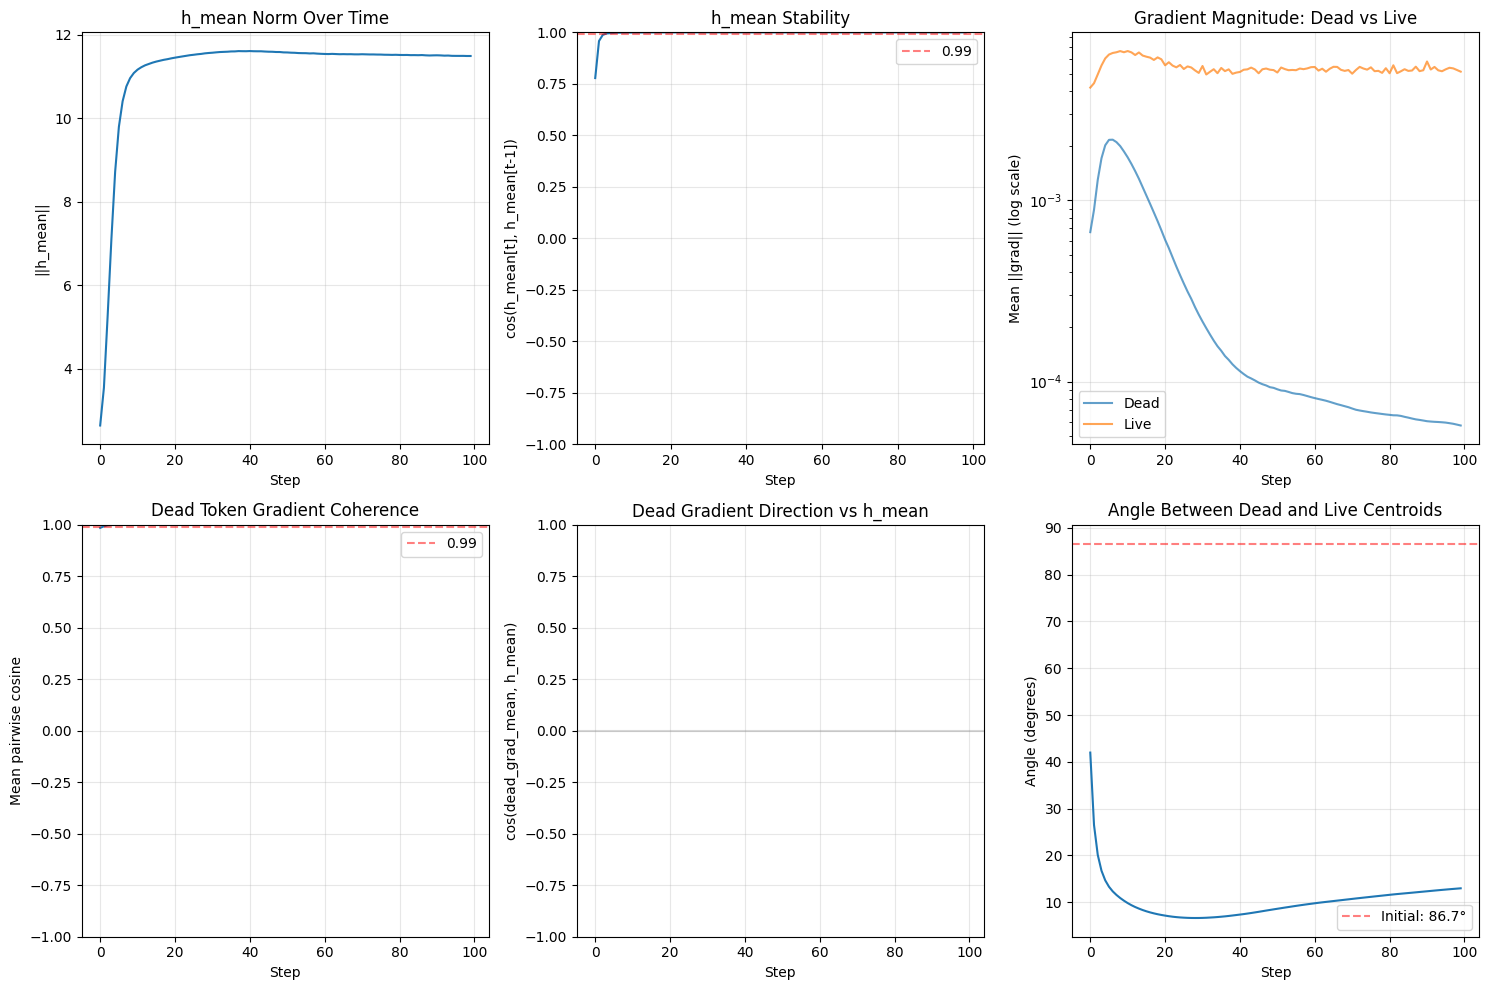

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. h_mean norm over time
ax = axes[0, 0]
ax.plot(h_mean_norms)
ax.set_xlabel('Step')
ax.set_ylabel('||h_mean||')
ax.set_title('h_mean Norm Over Time')
ax.grid(alpha=0.3)

# 2. h_mean stability (cosine between consecutive)
ax = axes[0, 1]
ax.plot(h_mean_stability)
ax.set_xlabel('Step')
ax.set_ylabel('cos(h_mean[t], h_mean[t-1])')
ax.set_title('h_mean Stability')
ax.set_ylim(-1, 1)
ax.axhline(y=0.99, color='r', linestyle='--', alpha=0.5, label='0.99')
ax.legend()
ax.grid(alpha=0.3)

# 3. Gradient norms (dead vs live)
ax = axes[0, 2]
ax.semilogy(dead_grad_norms, label='Dead', alpha=0.7)
ax.semilogy(live_grad_norms, label='Live', alpha=0.7)
ax.set_xlabel('Step')
ax.set_ylabel('Mean ||grad|| (log scale)')
ax.set_title('Gradient Magnitude: Dead vs Live')
ax.legend()
ax.grid(alpha=0.3)

# 4. Dead token movement coherence
ax = axes[1, 0]
ax.plot(dead_move_coherence)
ax.set_xlabel('Step')
ax.set_ylabel('Mean pairwise cosine')
ax.set_title('Dead Token Gradient Coherence')
ax.set_ylim(-1, 1)
ax.axhline(y=0.99, color='r', linestyle='--', alpha=0.5, label='0.99')
ax.legend()
ax.grid(alpha=0.3)

# 5. Dead gradient vs h_mean correlation
ax = axes[1, 1]
ax.plot(dead_move_vs_h)
ax.set_xlabel('Step')
ax.set_ylabel('cos(dead_grad_mean, h_mean)')
ax.set_title('Dead Gradient Direction vs h_mean')
ax.set_ylim(-1, 1)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.grid(alpha=0.3)

# 6. Centroid angle over time
ax = axes[1, 2]
ax.plot(centroid_angles)
ax.axhline(y=angle_init, color='r', linestyle='--', alpha=0.5, label=f'Initial: {angle_init:.1f}°')
ax.set_xlabel('Step')
ax.set_ylabel('Angle (degrees)')
ax.set_title('Angle Between Dead and Live Centroids')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sanity_checks@72.png', dpi=72)
plt.show()

## Summary Statistics

In [10]:
print("="*60)
print("SANITY CHECK RESULTS")
print("="*60)

print(f"\n1. h_mean convergence:")
print(f"   Final h_mean norm: {h_mean_norms[-1]:.4f}")
print(f"   Stability (last 10 steps): {np.mean(h_mean_stability[-10:]):.4f}")

print(f"\n2. Dead token gradients:")
print(f"   Step 1 dead grad norm: {dead_grad_norms[0]:.2e}")
print(f"   Step 1 live grad norm: {live_grad_norms[0]:.2e}")
print(f"   Ratio (live/dead): {live_grad_norms[0]/dead_grad_norms[0]:.1f}x")

print(f"\n3. Dead token coherence:")
print(f"   Step 1 coherence: {dead_move_coherence[0]:.4f}")
print(f"   Mean coherence: {np.mean(dead_move_coherence):.4f}")

print(f"\n4. Dead gradient vs h_mean:")
print(f"   Step 1: {dead_move_vs_h[0]:.4f}")
print(f"   Mean: {np.mean(dead_move_vs_h):.4f}")
print(f"   (Theory predicts ~1.0 or ~-1.0)")

print(f"\n5. Centroid separation:")
print(f"   Initial angle: {angle_init:.1f}°")
print(f"   Final angle: {centroid_angles[-1]:.1f}°")
print(f"   Change: {centroid_angles[-1] - angle_init:+.1f}°")

print("\n" + "="*60)

SANITY CHECK RESULTS

1. h_mean convergence:
   Final h_mean norm: 11.4929
   Stability (last 10 steps): 0.9999

2. Dead token gradients:
   Step 1 dead grad norm: 6.68e-04
   Step 1 live grad norm: 4.19e-03
   Ratio (live/dead): 6.3x

3. Dead token coherence:
   Step 1 coherence: 0.9852
   Mean coherence: 0.9997

4. Dead gradient vs h_mean:
   Step 1: 1.0000
   Mean: 1.0000
   (Theory predicts ~1.0 or ~-1.0)

5. Centroid separation:
   Initial angle: 86.7°
   Final angle: 13.0°
   Change: -73.7°



## Interpretation

**What we expected (theory):**
- h_mean should converge quickly and stay stable
- Dead tokens should get nonzero gradients from step 1
- Dead token gradients should be highly coherent (all moving same direction)
- Dead gradient direction should correlate with h_mean (positive or negative)
- Centroids should separate over time

**What we saw:**

*(Fill in after running)*